# Open merged.parquet & get *n* random rows

In [13]:
import pandas as pd
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_parquet("E:\\parquet\\EG.5_58-Fc_11_d4e54875-ce9a-11f0-8905-f02f74d321c5.parquet")
df

,FSC-H,SSC-H,FITC-H,FSC-A,SSC-A,FITC-A,label,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,gmm_prob_infected
0,170527.0,119387.0,637.0,907963.63,640065.13,3768.03,False,3768.03,3.576230,2.036860,0.61028,0.371076,5.324457,5.361263,9.421781e-01
1,179163.0,91273.0,478.0,996533.31,504927.88,2928.31,False,2928.31,3.466765,1.795529,0.39870,-0.351815,5.562160,5.532062,9.281705e-01
2,161510.0,143253.0,511.0,871144.69,747696.50,2784.38,False,2784.38,3.444884,1.747962,0.36140,-0.496314,5.393751,5.219413,9.211127e-01
3,194785.0,198536.0,586.0,1074537.13,1122680.25,3468.88,False,3468.88,3.540314,1.957136,0.54091,0.133896,5.516529,5.654794,9.407712e-01
4,162182.0,112947.0,558.0,946926.88,637583.38,3596.72,False,3596.72,3.556027,1.991958,0.57090,0.237662,5.838668,5.644978,9.417249e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7215.0,2171.0,131.0,19893.88,5289.44,168.59,False,168.59,2.229400,0.167801,0.05105,-8.523248,2.757295,2.436407,1.322311e-14
49996,147706.0,97694.0,785.0,818875.25,553902.50,5203.31,False,5203.31,3.716363,2.351551,0.81430,1.296504,5.543954,5.669770,9.182127e-01
49997,164753.0,138055.0,615.0,940537.50,747311.25,3551.00,False,3551.00,3.550473,1.979638,0.56108,0.200982,5.708773,5.413142,9.414490e-01
49998,21751.0,50112.0,132.0,91065.66,207382.13,308.34,False,308.34,2.490436,0.303652,0.08931,-6.799394,4.186734,4.138373,2.523009e-09


In [15]:
df_label_0 = df[df["label"] == 0]
df_label_1 = df[df["label"] == 1]

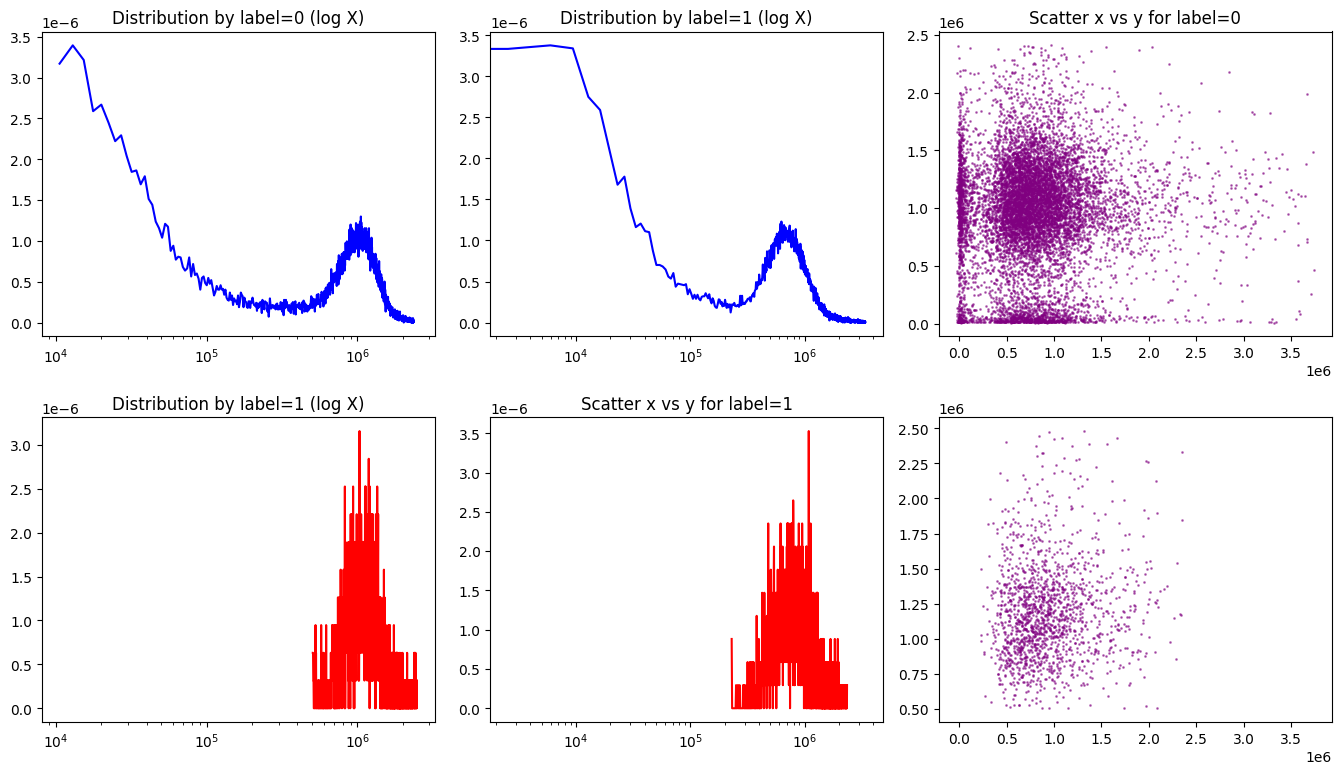

In [16]:
def clip_outliers(arr, lower_percentile=1, upper_percentile=99):
    low = np.percentile(arr, lower_percentile)
    high = np.percentile(arr, upper_percentile)
    return arr[(arr >= low) & (arr <= high)]

def plot_distributions_and_scatter(x, y, a, b, x_scatter_label_0, y_scatter_label_0, x_scatter_label_1, y_scatter_label_1, bins=1000):
    # --- считаем гистограммы ---
    p_hist, p_bins = np.histogram(x, bins=bins, density=True)
    q_hist, q_bins = np.histogram(y, bins=bins, density=True)

    # добавим маленькую константу
    p = p_hist + 1e-12
    q = q_hist + 1e-12

    # центры бинов для оси X
    p_centers = 0.5 * (p_bins[:-1] + p_bins[1:])
    q_centers = 0.5 * (q_bins[:-1] + q_bins[1:])

    a_hist, a_bins = np.histogram(a, bins=bins, density=True)
    b_hist, b_bins = np.histogram(b, bins=bins, density=True)

    # добавим маленькую константу
    a = a_hist + 1e-12
    b = b_hist + 1e-12

    # центры бинов для оси X
    a_centers = 0.5 * (a_bins[:-1] + a_bins[1:])
    b_centers = 0.5 * (b_bins[:-1] + b_bins[1:])

    # --- создаём 3 сабплота ---
    fig = plt.figure(figsize=(18, 8))
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1])

    ax1 = fig.add_subplot(gs[0, 0])   # верхний левый
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)   # нижний левый
    ax3 = fig.add_subplot(gs[0, 1])   # правый (scatter)
    ax4 = fig.add_subplot(gs[1, 1], sharex=ax3)   # правый (scatter)
    ax5 = fig.add_subplot(gs[0, 2])
    ax6 = fig.add_subplot(gs[1, 2], sharex=ax5)

    # --- 1: верхняя линия ---
    ax1.plot(p_centers, p, color='blue')
    ax1.set_title("Distribution by label=0 (log X)")
    ax1.set_xscale("log")

    # --- 2: нижняя линия ---
    ax2.plot(q_centers, q, color='red')
    ax2.set_title("Distribution by label=1 (log X)")
    ax2.set_xscale("log")

    # --- 3: двойной scatter ---
    ax3.plot(a_centers, a, color='blue')
    ax3.set_title("Distribution by label=1 (log X)")
    ax3.set_xscale("log")

    ax4.plot(b_centers, b, color='red')
    ax4.set_title("Distribution by label=1 (log X)")
    ax4.set_xscale("log")

    ax5.scatter(x_scatter_label_0, y_scatter_label_0, s=1, alpha=0.5, color='purple')
    ax5.set_title("Scatter x vs y for label=0")

    ax6.scatter(x_scatter_label_1, y_scatter_label_1, s=1, alpha=0.5, color='purple')
    ax4.set_title("Scatter x vs y for label=1")

    plt.tight_layout()
    plt.show()

low_percentile=1
high_persentile=99

plot_distributions_and_scatter(
    clip_outliers(df_label_0["FSC-A"].values, low_percentile, high_persentile), 
    clip_outliers(df_label_1["FSC-A"].values, low_percentile, high_persentile), 
    clip_outliers(df_label_0["SSC-A"].values, low_percentile, high_persentile), 
    clip_outliers(df_label_1["SSC-A"].values, low_percentile, high_persentile),
    clip_outliers(df_label_0["SSC-A"].values[:10000], low_percentile, high_persentile), 
    clip_outliers(df_label_0["FSC-A"].values[:10000], low_percentile, high_persentile), 
    clip_outliers(df_label_1["SSC-A"].values[:10000], low_percentile, high_persentile), 
    clip_outliers(df_label_1["FSC-A"].values[:10000], low_percentile, high_persentile),
    )

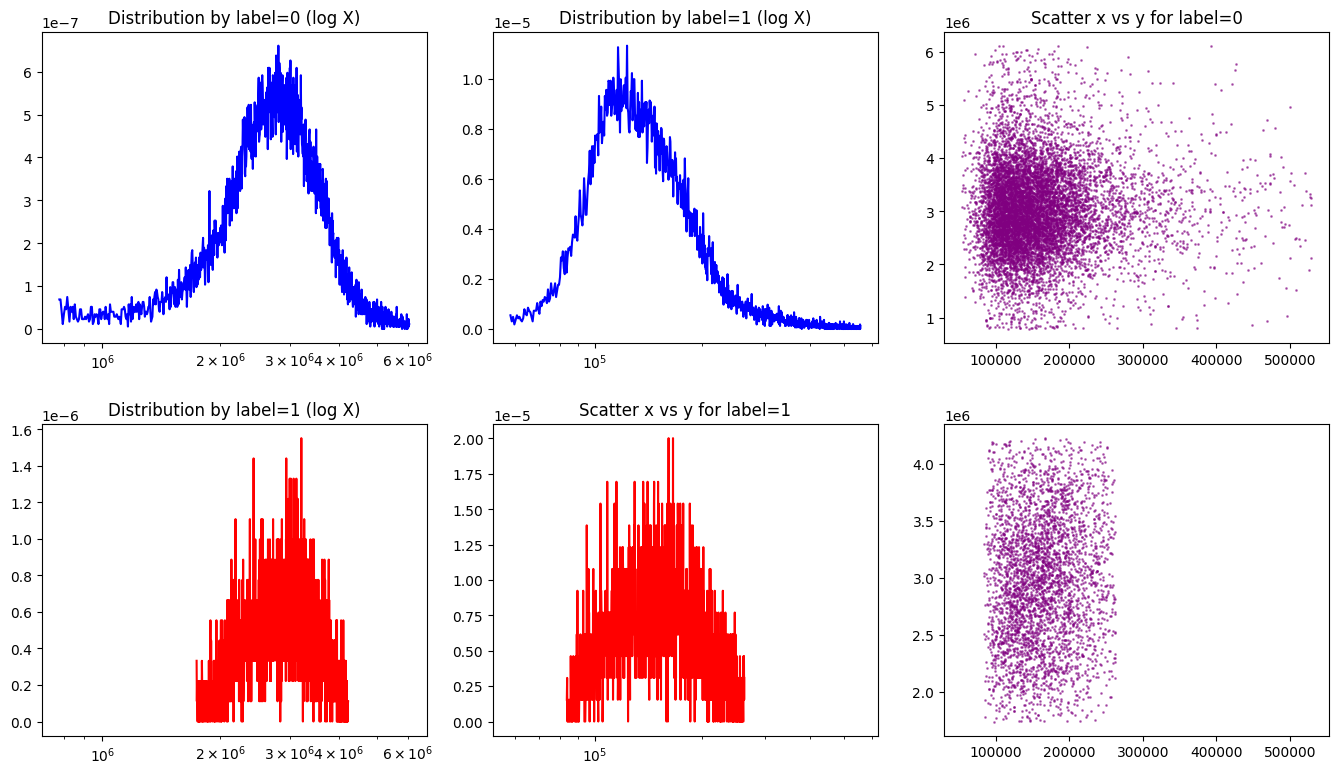

In [95]:
low_percentile=1
high_persentile=99

df1 = pd.read_parquet("E:\\parquet\\JN.1_7-35-57_7_a772f627-ce99-11f0-90bd-f02f74d321c5.parquet")
df1_label_0 = df1[df1["label"] == 0]
df1_label_1 = df1[df1["label"] == 1]

plot_distributions_and_scatter(
    clip_outliers(df_label_0["FSC-A"].values, low_percentile, high_persentile), 
    clip_outliers(df_label_1["FSC-A"].values, low_percentile, high_persentile), 
    clip_outliers(df_label_0["SSC-A"].values, low_percentile, high_persentile), 
    clip_outliers(df_label_1["SSC-A"].values, low_percentile, high_persentile),
    clip_outliers(df_label_0["SSC-A"].values[:10000], low_percentile, high_persentile), 
    clip_outliers(df_label_0["FSC-A"].values[:10000], low_percentile, high_persentile), 
    clip_outliers(df_label_1["SSC-A"].values[:10000], low_percentile, high_persentile), 
    clip_outliers(df_label_1["FSC-A"].values[:10000], low_percentile, high_persentile),
    )

In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter, label
import matplotlib.pyplot as plt

def select_central_cluster_by_centroid(clusters, XYs):
    """Выбрать кластер, чей центроид ближе всего к медиане всего набора (т.е. 'центральный')."""
    unique = np.unique(clusters)
    unique = unique[unique != -1]  # -1 = шум для DBSCAN
    if len(unique) == 0:
        return None
    global_med = np.median(XYs, axis=0)
    best = None
    best_dist = np.inf
    for u in unique:
        mask = clusters == u
        centroid = XYs[mask].mean(axis=0)
        d = np.linalg.norm(centroid - global_med)
        if d < best_dist:
            best_dist = d
            best = u
    return best

def filter_by_dbscan(x, y, eps=0.05, min_samples=50, **pre_kwargs):
    print(x)
    print(y)
    XYs, x_trim, y_trim, scaler = preprocess_xy(x, y, **pre_kwargs)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(XYs)
    labels = db.labels_
    chosen = select_central_cluster_by_centroid(labels, XYs)
    mask = (labels == chosen)
    return mask, XYs, x_trim, y_trim, labels

def filter_by_gmm(x, y, n_components=3, **pre_kwargs):
    XYs, x_trim, y_trim, scaler = preprocess_xy(x, y, **pre_kwargs)
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(XYs)
    labels = gmm.predict(XYs)
    chosen = select_central_cluster_by_centroid(labels, XYs)
    mask = (labels == chosen)
    return mask, XYs, x_trim, y_trim, labels

def filter_by_kde_threshold(x, y, grid_size=200, bandwidth=None, frac_keep=0.5, **pre_kwargs):
    """
    2D KDE + thresholding: выбираем клетки с плотностью выше порога (например, верхние frac_keep).
    Затем берем компонент, который ближе к центру.
    """
    XYs, x_trim, y_trim, scaler = preprocess_xy(x, y, **pre_kwargs)
    # KDE in original (trimmed & log) space:
    kde = gaussian_kde(np.vstack([XYs[:,0], XYs[:,1]]), bw_method=bandwidth)
    # grid
    xmin, ymin = XYs.min(axis=0)
    xmax, ymax = XYs.max(axis=0)
    xi = np.linspace(xmin, xmax, grid_size)
    yi = np.linspace(ymin, ymax, grid_size)
    xx, yy = np.meshgrid(xi, yi)
    grid_coords = np.vstack([xx.ravel(), yy.ravel()])
    zz = kde(grid_coords).reshape(grid_size, grid_size)
    # smooth and threshold
    zzs = gaussian_filter(zz, sigma=1.0)
    thresh = np.percentile(zzs.ravel(), 100*(1-frac_keep))
    mask_cells = zzs >= thresh
    # label connected regions
    labeled, ncomp = label(mask_cells)
    if ncomp == 0:
        return np.ones(len(XYs), dtype=bool), XYs, x_trim, y_trim, None
    # map each point to cell index to get component id
    ix = np.searchsorted(xi, XYs[:,0]) - 1
    iy = np.searchsorted(yi, XYs[:,1]) - 1
    # clip indices
    ix = np.clip(ix, 0, grid_size-1)
    iy = np.clip(iy, 0, grid_size-1)
    comp_ids = labeled[iy, ix]
    # choose component whose centroid is closest to global median
    unique = np.unique(comp_ids)
    unique = unique[unique != 0]  # 0 = background
    global_med = np.median(XYs, axis=0)
    best = None
    best_dist = np.inf
    for u in unique:
        pts = XYs[comp_ids == u]
        if len(pts) == 0:
            continue
        centroid = pts.mean(axis=0)
        d = np.linalg.norm(centroid - global_med)
        if d < best_dist:
            best_dist = d
            best = u
    mask = comp_ids == best
    return mask, XYs, x_trim, y_trim, comp_ids

from sklearn.preprocessing import RobustScaler

def preprocess_xy(x, y, log=True, eps=1e-9, lower_p=1, upper_p=99):
    """Приведение данных: отсечь экстремальные процентили и (опционально) логарифмировать безопасно."""

    # убираем NaN в исходных данных
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x0 = x[mask]
    y0 = y[mask]

    # отрезаем экстремальные процентили
    lo_x, hi_x = np.percentile(x0, [lower_p, upper_p])
    lo_y, hi_y = np.percentile(y0, [lower_p, upper_p])
    mask2 = (x0 >= lo_x) & (x0 <= hi_x) & (y0 >= lo_y) & (y0 <= hi_y)
    x1 = x0[mask2]
    y1 = y0[mask2]

    if log:
        # безопасный логарифм: отрицательные значения или нули превращаем в NaN
        def safe_log10(arr):
            arr_safe = arr + eps
            arr_safe[arr_safe <= 0] = np.nan
            return np.log10(arr_safe)

        x1 = safe_log10(x1)
        y1 = safe_log10(y1)

    # после логарифмирования могут появиться NaN: убираем их
    mask_finite = np.isfinite(x1) & np.isfinite(y1)
    x1 = x1[mask_finite]
    y1 = y1[mask_finite]

    # масштабируем робастно (median + IQR)
    XY = np.vstack([x1, y1]).T
    scaler = RobustScaler()
    XYs = scaler.fit_transform(XY)

    return XYs, x1, y1, scaler

# ------------------------
# Пример использования и визуализация
# ------------------------
def visualize_filter_linear(x, y, mask, XYs=None, title="filtered"):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.scatter(XYs[:,0], XYs[:,1], s=1, alpha=0.2, label='all')
    plt.scatter(XYs[mask,0], XYs[mask,1], s=2, alpha=0.8, label='selected')
    plt.legend()
    plt.title(title + " (linear)")
    
    # задаём границы по перцентилям
    low_p, high_p = 1, 99
    plt.xlim(np.percentile(XYs[:,0], [low_p, high_p]))
    plt.ylim(np.percentile(XYs[:,1], [low_p, high_p]))
    
    plt.subplot(1,2,2)
    plt.hist(XYs[:,0], bins=100, alpha=0.3, density=True, label='all x')
    plt.hist(XYs[mask,0], bins=100, alpha=0.5, density=True, label='sel x')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [19]:
# df1 = df1.dropna()
x = df["FSC-A"].values
y = df["SSC-A"].values

In [20]:
has_nan = np.isnan(x).any()
print(has_nan)

False


# Учим фильтровать SSC-A/FSC-A

=== Start DBSCAN filtering ===
[ 907963.63  996533.31  871144.69 ...  940537.5    91065.66 1536740.25]
[ 640065.13  504927.88  747696.5  ...  747311.25  207382.13 1027725.  ]
DBSCAN filtering done in 1.35 seconds
=== Start visualization ===


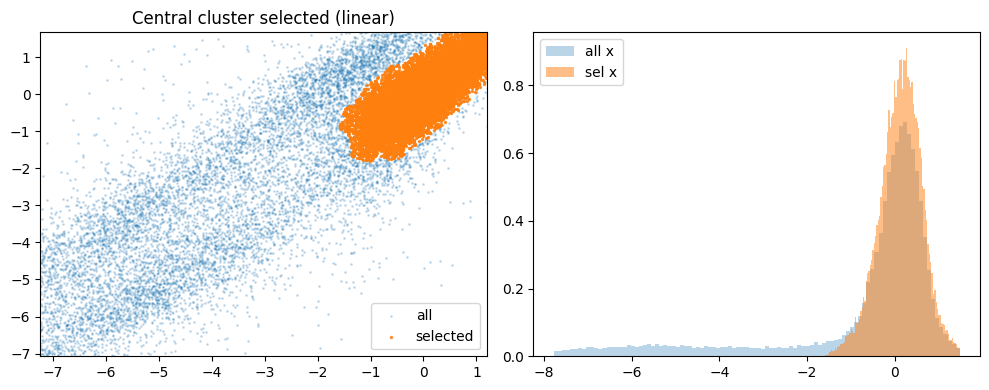

Visualization done in 1.90 seconds
Total time: 3.26 seconds


In [21]:
import time

start_total = time.time()
print("=== Start DBSCAN filtering ===")
start_dbscan = time.time()
mask, XYs, x_trim, y_trim, labels = filter_by_dbscan(
    x, y,
    eps=0.15,        # чувствительность к плотности
    min_samples=50,  # минимальный размер кластера
    log=True,        # логарифмирование осей
    lower_p=1,       # отсечение 1%-го перцентиля
    upper_p=99       # отсечение 99%-го перцентиля
)
end_dbscan = time.time()
print(f"DBSCAN filtering done in {end_dbscan - start_dbscan:.2f} seconds")

print("=== Start visualization ===")
start_viz = time.time()
visualize_filter_linear(x, y, mask, XYs=XYs, title="Central cluster selected")
end_viz = time.time()
print(f"Visualization done in {end_viz - start_viz:.2f} seconds")

end_total = time.time()
print(f"Total time: {end_total - start_total:.2f} seconds")

=== Start GMM filtering ===
GMM filtering done in 0.22 seconds
=== Start visualization ===


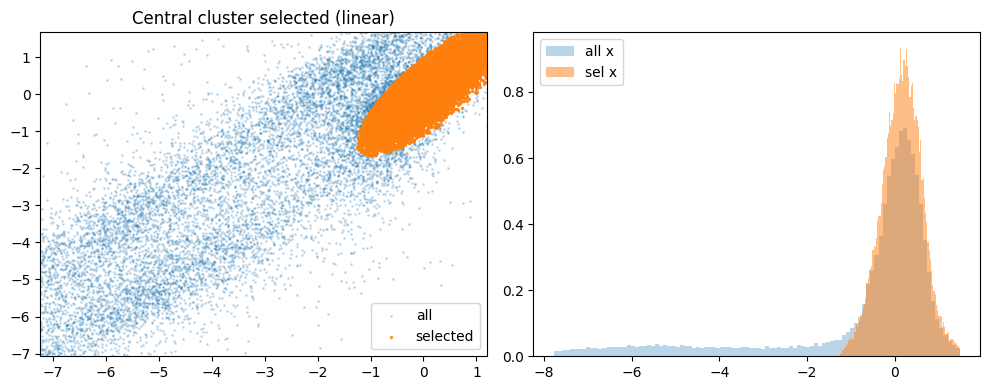

Visualization done in 1.99 seconds
Total time: 2.21 seconds


In [22]:
start_total = time.time()

print("=== Start GMM filtering ===")
start_gmm = time.time()
mask, XYs, x_trim, y_trim, labels = filter_by_gmm(
    x, y,
    n_components=2,  # число пиков в данных
    log=True,
    lower_p=1,
    upper_p=99
)
end_gmm = time.time()
print(f"GMM filtering done in {end_gmm - start_gmm:.2f} seconds")

print("=== Start visualization ===")
start_viz = time.time()
visualize_filter_linear(x, y, mask, XYs=XYs, title="Central cluster selected")
end_viz = time.time()
print(f"Visualization done in {end_viz - start_viz:.2f} seconds")

end_total = time.time()
print(f"Total time: {end_total - start_total:.2f} seconds")

=== Start KDE filtering ===
KDE filtering done in 37.03 seconds
=== Start visualization ===


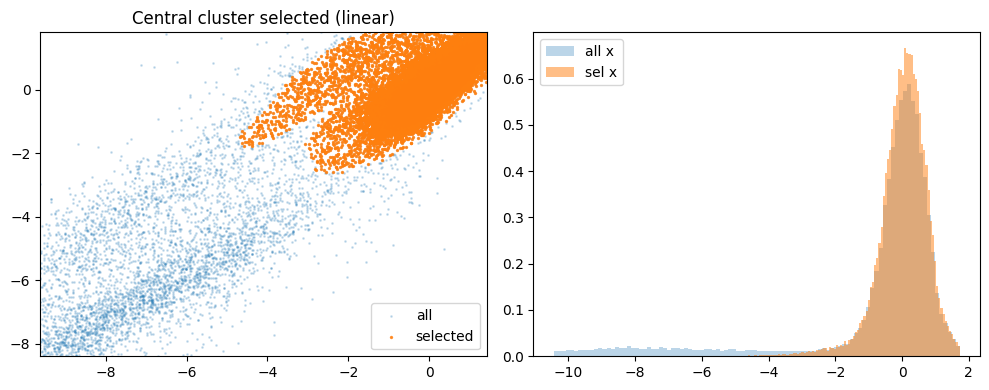

Visualization done in 1.07 seconds
Total time: 38.10 seconds


In [42]:
start_total = time.time()

print("=== Start KDE filtering ===")
start_gmm = time.time()
mask, XYs, x_trim, y_trim, comp_ids = filter_by_kde_threshold(
    x, y,
    grid_size=200,
    frac_keep=0.2,  # верхние 20% плотности
    log=True,
    lower_p=1,
    upper_p=99
)
end_gmm = time.time()
print(f"KDE filtering done in {end_gmm - start_gmm:.2f} seconds")

print("=== Start visualization ===")
start_viz = time.time()
visualize_filter_linear(x, y, mask, XYs=XYs, title="Central cluster selected")
end_viz = time.time()
print(f"Visualization done in {end_viz - start_viz:.2f} seconds")

end_total = time.time()
print(f"Total time: {end_total - start_total:.2f} seconds")

# С наилучшими результатами побеждает DBSCAN. Его и будем использовать.

In [23]:
import time
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KDTree
import joblib  # pip install joblib
import pandas as pd

# ---------- вспомогательная предобработка ----------
def preprocess_xy_for_model(x, y, log=True, eps_shift=1e-9,
    lower_p=1, upper_p=99,
    user_thresholds=None):
    """
    Возвращает:
    - XYs: numpy array (M,2) - преобразованные данные (после clip, log, scaler.transform)
      (M <= len(x), только реально прошедшие фильтры точки)
    - raw_trim_x, raw_trim_y: массивы значений после обрезки/логирования (length M)
    - meta: dict с порогами и безмасштабными вещами (lo_x, hi_x, lo_y, hi_y)
    - mask_kept: boolean array length len(x) — True для исходных индексов, которые попали в XYs
    """
    orig_len = len(x)
    # mask nan (по парам)
    mask_not_nan = (~np.isnan(x)) & (~np.isnan(y))
    x0 = x[mask_not_nan].astype(float)
    y0 = y[mask_not_nan].astype(float)

    # определяем пороги
    if user_thresholds is None:
        if x0.size == 0 or y0.size == 0:
            lo_x = hi_x = lo_y = hi_y = 0.0
        else:
            lo_x, hi_x = np.percentile(x0, [lower_p, upper_p])
            lo_y, hi_y = np.percentile(y0, [lower_p, upper_p])
    else:
        lo_x = user_thresholds['lo_x']; hi_x = user_thresholds['hi_x']
        lo_y = user_thresholds['lo_y']; hi_y = user_thresholds['hi_y']

    # clip (отрезаем экстремумы)
    if x0.size == 0:
        x_clip = np.empty(0)
        y_clip = np.empty(0)
    else:
        x_clip = np.clip(x0, lo_x, hi_x)
        y_clip = np.clip(y0, lo_y, hi_y)

    # логируем безопасно, заменяем отрицательные или нулевые значения на NaN
    if log:
        def safe_log10(arr):
            arr_safe = arr + eps_shift
            arr_safe[arr_safe <= 0] = np.nan
            return np.log10(arr_safe)
        x_proc = safe_log10(x_clip)
        y_proc = safe_log10(y_clip)
    else:
        x_proc = x_clip
        y_proc = y_clip

    # удаляем NaN / inf после логарифмирования
    if x_proc.size == 0:
        mask_finite = np.array([], dtype=bool)
    else:
        mask_finite = np.isfinite(x_proc) & np.isfinite(y_proc)
        x_proc = x_proc[mask_finite]
        y_proc = y_proc[mask_finite]

    XYs = np.vstack([x_proc, y_proc]).T if x_proc.size > 0 else np.empty((0,2))

    # mask_kept : boolean mask по исходным индексам
    mask_kept = np.zeros(orig_len, dtype=bool)
    if mask_not_nan.any():
        idx_not_nan = np.nonzero(mask_not_nan)[0]    # индексы исходного массива, где не nan
        if mask_finite.size > 0:
            idx_kept = idx_not_nan[mask_finite]
            mask_kept[idx_kept] = True

    meta = {'lo_x': float(lo_x), 'hi_x': float(hi_x),
            'lo_y': float(lo_y), 'hi_y': float(hi_y),
            'log': bool(log)}

    return XYs, x_proc, y_proc, meta, mask_kept

# ---------- train DBSCAN (fit on sample) ----------
def train_dbscan_model(x, y,
                       eps=0.15, min_samples=50,
                       log=True, lower_p=1, upper_p=99,
                       sample_size=None, random_state=0):
    """
    Возвращает словарь model:
      model = {
        'db': fitted DBSCAN object,
        'scaler': RobustScaler fitted on transformed data,
        'tree': KDTree built on core samples (in scaled space),
        'core_labels': labels for each core sample ( aligned with tree.data ),
        'eps': eps (в пространстве после scaler.transform),
        'meta': {'lo_x','hi_x','lo_y','hi_y','log'}
      }
    sample_size: если задано — сначала делаем случайную подвыборку для обучения.
    """
    t0 = time.time()
    # если нужен sample - берём индексы
    n = len(x)
    if (sample_size is not None) and (sample_size < n):
        rng = np.random.RandomState(random_state)
        idx = rng.choice(n, size=sample_size, replace=False)
        x_train = x[idx]
        y_train = y[idx]
    else:
        x_train = x
        y_train = y

    # Preprocess (clip + log)
    XY_train, x_trim, y_trim, meta, mask_kept_train = preprocess_xy_for_model(
        x_train, y_train, log=log, lower_p=lower_p, upper_p=upper_p
    )

    # Масштабируем робастно
    scaler = RobustScaler()
    XYs = scaler.fit_transform(XY_train)

    # Подбираем/обучаем DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    db.fit(XYs)
    labels = db.labels_
    t1 = time.time()

    # core samples
    core_idx = db.core_sample_indices_
    if len(core_idx) == 0:
        print("WARNING: DBSCAN found no core samples (all noise).")
        core_points = np.empty((0,2))
        core_labels = np.array([], dtype=int)
        tree = None
    else:
        core_points = XYs[core_idx]            # в scaled-пространстве
        core_labels = labels[core_idx]
        tree = KDTree(core_points)             # для быстрого соответствия новых точек
    t2 = time.time()

    model = {
        'db': db,
        'scaler': scaler,
        'tree': tree,
        'core_labels': core_labels,
        'core_points': core_points,
        'eps': float(eps),
        'meta': meta,
        'orig_sample_size': len(XY_train),
        'train_time': t1 - t0,
        'postproc_time': t2 - t1
    }
    print(f"Train: preprocess+fit DBSCAN: {model['train_time']:.2f}s, tree build: {model['postproc_time']:.2f}s, cores: {len(core_idx)}")
    return model

# ---------- predict / map labels for new data ----------
def predict_dbscan_model(model, x_new, y_new, assign_method='nearest'):
    """
    Возвращает labels_new (np.array length len(x_new)), где -1 = noise, иначе метка кластера.
    """
    meta = model['meta']
    log = meta['log']
    # применяем те же пороги (meta.lo_x etc)
    user_th = {'lo_x': meta['lo_x'], 'hi_x': meta['hi_x'], 'lo_y': meta['lo_y'], 'hi_y': meta['hi_y']}
    XY_new_raw, x_clip, y_clip, _, mask_kept = preprocess_xy_for_model(x_new, y_new, log=log, user_thresholds=user_th)

    # если нет ни одной "валидной" точки после предобработки — вернём -1 для всех исходных
    n_all = len(x_new)
    labels_full = np.full(n_all, -1, dtype=int)
    if XY_new_raw.size == 0:
        return labels_full

    # масштабируем тем же scaler
    XY_new = model['scaler'].transform(XY_new_raw)

    # если нет core samples / дерево
    if (model['tree'] is None) or (len(model['core_points']) == 0):
        return labels_full

    tree = model['tree']
    core_labels = model['core_labels']
    eps = model['eps']

    # ближайший neighbor + проверка расстояния
    dist, idx = tree.query(XY_new, k=1)
    dist = dist.ravel()
    idx = idx.ravel()
    labels_assigned = np.full(len(XY_new), -1, dtype=int)
    within = dist <= eps
    labels_assigned[within] = core_labels[idx[within]]

    # развернём в полный вектор длины len(x_new)
    labels_full[mask_kept] = labels_assigned

    return labels_full

# ---------- save / load ----------
def save_dbscan_model(model, path):
    joblib.dump(model, path)

def load_dbscan_model(path):
    return joblib.load(path)

import time

# 1) training на выборке из первого файла (можно взять sample_size=200_000)
start = time.time()
model = train_dbscan_model(
    x = df["FSC-A"].values, 
    y = df["SSC-A"].values,
    eps = 0.15,
    min_samples = 50,
    log = True,
    lower_p = 1,
    upper_p = 99,
    sample_size = 200_000,   # обучаем на подвыборке
    random_state = 42
)
print("Train total time:", time.time() - start)

# Сохраним модель на диск
# save_dbscan_model(model, "dbscan_model.joblib")

df_new = pd.read_parquet("E:\\parquet\\EG.5_58-35-57_9_3e463980-ce9a-11f0-beee-f02f74d321c5.parquet")
# apply to new df (in memory)
t1 = time.time()
labels_new = predict_dbscan_model(model, df_new['FSC-A'].values, df_new['SSC-A'].values)
print("Predict in-memory finished in", time.time()-t1)
print("Selected fraction:", (labels_new != -1).mean())


Train: preprocess+fit DBSCAN: 1.05s, tree build: 0.02s, cores: 37939
Train total time: 1.071181058883667
Predict in-memory finished in 0.0655202865600586
Selected fraction: 0.84534


Train: preprocess+fit DBSCAN: 0.16s, tree build: 0.01s, cores: 16618
Train total time: 0.16975164413452148


In [144]:
type(model)
print(model.keys() if isinstance(model, dict) else model)

dict_keys(['db', 'scaler', 'tree', 'core_labels', 'core_points', 'eps', 'meta', 'orig_sample_size', 'train_time', 'postproc_time'])


In [145]:
df_new = pd.read_parquet("E:\\parquet\\JN.1_7-35-57_7_a772f627-ce99-11f0-90bd-f02f74d321c5.parquet")
# apply to new df (in memory)
t1 = time.time()
labels_new = predict_dbscan_model(model, df_new['FSC-A'].values, df_new['SSC-A'].values)
print("Predict in-memory finished in", time.time()-t1)
print("Selected fraction:", (labels_new != -1).mean())

# apply to big parquet file by chunks (see function выше)
# apply_model_to_parquet_in_chunks(model, "big.parquet", x_col='FSC-A', y_col='SSC-A', chunksize=500_000, out_path="selected_rows.csv")

Predict in-memory finished in 0.02451157569885254
Selected fraction: 0.7921651961010764


In [157]:
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# --------------------------------------------------
# Функция: обработка файла (read -> predict -> stats -> plot)
# --------------------------------------------------
def process_and_visualize_files(
    file_paths,
    model,
    x_col="FSC-A",
    y_col="SSC-A",
    read_chunksize=None,        # if None -> read whole file; if int -> iterate chunks (for csv)
    sample_frac_for_plot=0.05,  # доля точек для визуализации (cap применяется)
    sample_cap=200_000,         # максимум точек для визуализации
    out_dir="results_vis",
    predict_fn=None,            # callable(model, x_array, y_array) -> labels
):
    """
    file_paths: list of paths (str or Path) to files (csv or parquet).
    model: trained model object (as returned by train_dbscan_model).
    predict_fn: optional: callable(model, x_array, y_array) -> np.array(labels).
                If None, uses predict_dbscan_model from your workspace.
    """
    # default predict fn
    if predict_fn is None:
        try:
            predict_fn = predict_dbscan_model  # предполагается, что функция в сессии
        except NameError:
            raise RuntimeError("predict_fn is not provided and predict_dbscan_model is not found in the environment.")

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    for fp in file_paths:
        fp = Path(fp)
        print(f"\n--- Processing file: {fp} ---")
        t0_file = time.perf_counter()

        # read file (full or in chunks)
        if fp.suffix.lower() in [".parquet", ".pq"]:
            # read full parquet (files are 'not very big' по твоим словам)
            df = pd.read_parquet(fp)
            read_time = 0.0
            print(f"Read parquet: {len(df):,} rows")
        elif fp.suffix.lower() in [".csv", ".txt"]:
            if read_chunksize is None:
                t0r = time.perf_counter()
                df = pd.read_csv(fp)
                read_time = time.perf_counter() - t0r
                print(f"Read csv full: {len(df):,} rows, {read_time:.2f}s")
            else:
                # если указан chunksize, прочитаем по чанкам и конкатенируем только интересующие колонки
                t0r = time.perf_counter()
                chunks = []
                for chunk in pd.read_csv(fp, usecols=[x_col, y_col], chunksize=read_chunksize):
                    chunks.append(chunk)
                df = pd.concat(chunks, ignore_index=True)
                read_time = time.perf_counter() - t0r
                print(f"Read csv by chunks -> total rows: {len(df):,}, read time {read_time:.2f}s")
        else:
            raise ValueError(f"Unsupported file extension: {fp.suffix}")

        # extract arrays (handle missing)
        x_all = df[x_col].to_numpy()
        y_all = df[y_col].to_numpy()

        # predict labels for entire file (timing)
        t0_pred = time.perf_counter()
        labels = predict_fn(model, x_all, y_all)
        pred_time = time.perf_counter() - t0_pred

        mask_selected = labels != -1
        total = len(labels)
        selected = int(mask_selected.sum())
        frac = selected / total if total > 0 else 0.0

        # simple stats: means/medians of selected vs all (on original clipped/log applied by model.predict)
        # Note: predict_dbscan_model clips & transforms internally; here we compute stats on raw values.
        def safe_stats(arr, mask=None):
            if mask is None:
                a = arr[~np.isnan(arr)]
            else:
                a = arr[mask & (~np.isnan(arr))]
            if len(a) == 0:
                return {"count":0, "mean":np.nan, "med":np.nan, "std":np.nan}
            return {"count":len(a), "mean":float(np.nanmean(a)), "med":float(np.nanmedian(a)), "std":float(np.nanstd(a))}
        stats_all_x = safe_stats(x_all, None)
        stats_sel_x = safe_stats(x_all, mask_selected)
        stats_all_y = safe_stats(y_all, None)
        stats_sel_y = safe_stats(y_all, mask_selected)

        # Save summary row
        rows.append({
            "file": str(fp),
            "rows": total,
            "selected": selected,
            "fraction": frac,
            "read_time_s": read_time,
            "predict_time_s": pred_time,
            "mean_x_all": stats_all_x["mean"],
            "mean_x_sel": stats_sel_x["mean"],
            "med_x_all": stats_all_x["med"],
            "med_x_sel": stats_sel_x["med"],
            "mean_y_all": stats_all_y["mean"],
            "mean_y_sel": stats_sel_y["mean"],
            "med_y_all": stats_all_y["med"],
            "med_y_sel": stats_sel_y["med"],
        })

        # ========== Visualization ==========
        # sample points for plotting
        rng = np.random.RandomState(0)
        sample_n = min(int(total * sample_frac_for_plot), sample_cap)
        sample_n = max(sample_n, 2000) if total >= 2000 else total  # ensure reasonable minimum
        idx_plot = rng.choice(total, size=sample_n, replace=False) if sample_n < total else np.arange(total)

        XY_plot_x = x_all[idx_plot]
        XY_plot_y = y_all[idx_plot]
        labels_plot = labels[idx_plot]
        mask_plot_sel = labels_plot != -1

        # build figure: left = scatter (tall), right top = hist X, right bottom = hist Y
        fig = plt.figure(figsize=(14,6))
        gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.3)
        ax_scatter = fig.add_subplot(gs[:, 0])   # left column spanning both rows
        ax_histx = fig.add_subplot(gs[0, 1])     # right-top
        ax_histy = fig.add_subplot(gs[1, 1])     # right-bottom

        # scatter: all as faint grey, selected colored
        ax_scatter.scatter(XY_plot_x, XY_plot_y, s=1, alpha=0.15, color="gray", label="all (sampled)")
        ax_scatter.scatter(XY_plot_x[mask_plot_sel], XY_plot_y[mask_plot_sel], s=2, alpha=0.7, color="tab:blue", label="selected")
        ax_scatter.set_xlabel(x_col)
        ax_scatter.set_ylabel(y_col)
        ax_scatter.set_title(f"{fp.name} — selected {selected}/{total} ({frac:.3%})")
        ax_scatter.legend(markerscale=4, fontsize=9)

        # histograms: X and Y marginals for all vs selected
        bins_x = 100
        bins_y = 100
        ax_histx.hist(XY_plot_x, bins=bins_x, alpha=0.25, density=True, label="all")
        ax_histx.hist(XY_plot_x[mask_plot_sel], bins=bins_x, alpha=0.6, density=True, label="selected")
        ax_histx.set_title(f"{x_col} marginal")
        ax_histx.legend(fontsize=8)

        ax_histy.hist(XY_plot_y, bins=bins_y, alpha=0.25, density=True, label="all")
        ax_histy.hist(XY_plot_y[mask_plot_sel], bins=bins_y, alpha=0.6, density=True, label="selected")
        ax_histy.set_title(f"{y_col} marginal")
        ax_histy.legend(fontsize=8)

        # optional: set axis limits to 1-99 percentiles to avoid extreme tail stretch
        try:
            xmin, xmax = np.percentile(XY_plot_x, [1, 99])
            ymin, ymax = np.percentile(XY_plot_y, [1, 99])
            ax_scatter.set_xlim(xmin, xmax)
            ax_scatter.set_ylim(ymin, ymax)
        except Exception:
            pass

        # add small text box with numeric stats
        stats_txt = (
            f"rows: {total:,}\n"
            f"selected: {selected:,} ({frac:.3%})\n\n"
            f"mean x all/sel: {stats_all_x['mean']:.2f}/{stats_sel_x['mean']:.2f}\n"
            f"med x all/sel: {stats_all_x['med']:.2f}/{stats_sel_x['med']:.2f}\n\n"
            f"mean y all/sel: {stats_all_y['mean']:.2f}/{stats_sel_y['mean']:.2f}\n"
            f"med y all/sel: {stats_all_y['med']:.2f}/{stats_sel_y['med']:.2f}\n"
        )
        # place text in top-left corner of the figure
        fig.text(0.02, 0.98, stats_txt, va="top", ha="left", fontsize=9, family="monospace",
                 bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

        # save fig
        out_fig = out_dir / f"{fp.stem}_selection.png"
        fig.savefig(out_fig, dpi=180, bbox_inches="tight")
        plt.close(fig)

        t_file_done = time.perf_counter()
        print(f"Predict time: {pred_time:.2f}s, plotting & saving: {t_file_done - t0_file - pred_time:.2f}s, total: {t_file_done - t0_file:.2f}s")
    # end for files

    summary = pd.DataFrame(rows)
    summary_path = out_dir / "summary_selection.csv"
    summary.to_csv(summary_path, index=False)
    print("\nAll done. Summary saved to:", summary_path)
    return summary
# --------------------------------------------------


In [159]:
# у тебя должен быть готов model (train_dbscan_model(...))
files = [
    "E:\\parquet\\JN.1_7-35-57_7_a772f627-ce99-11f0-90bd-f02f74d321c5.parquet", 
    "E:\\parquet\\KP.3.1.1_58-18-57-Fc_D9_bb677317-ce99-11f0-9b2d-f02f74d321c5.parquet", 
    "E:\\parquet\\EG.5_58-10-57_4_08abcc31-ce9a-11f0-b2e5-f02f74d321c5.parquet",
    "E:\\parquet\\KP.2_58-N-57_9_108af62e-ce9a-11f0-822d-f02f74d321c5.parquet",
    "E:\\parquet\\XFG_57-18-H18K(sa55)_B4_24d3a807-ce9a-11f0-81c2-f02f74d321c5.parquet",
    "E:\\parquet\\XFG_XFG_SA55_A10_41e5b654-ce9a-11f0-bfa6-f02f74d321c5.parquet",
    "E:\\parquet\\NB.1.8.1_58-35-H15K_A8_df8a8c82-ce99-11f0-8b9a-f02f74d321c5.parquet",
    ]
summary = process_and_visualize_files(files, model,
                                      x_col="FSC-A", y_col="SSC-A",
                                      read_chunksize=None,        # или число для csv-chunks
                                      sample_frac_for_plot=0.02,
                                      sample_cap=150_000,
                                      out_dir="results_vis")
print(summary)



--- Processing file: E:\parquet\JN.1_7-35-57_7_a772f627-ce99-11f0-90bd-f02f74d321c5.parquet ---
Read parquet: 21,910 rows
Predict time: 0.09s, plotting & saving: 0.62s, total: 0.71s

--- Processing file: E:\parquet\KP.3.1.1_58-18-57-Fc_D9_bb677317-ce99-11f0-9b2d-f02f74d321c5.parquet ---
Read parquet: 38,814 rows
Predict time: 0.07s, plotting & saving: 0.61s, total: 0.68s

--- Processing file: E:\parquet\EG.5_58-10-57_4_08abcc31-ce9a-11f0-b2e5-f02f74d321c5.parquet ---
Read parquet: 50,000 rows
Predict time: 0.21s, plotting & saving: 0.85s, total: 1.05s

--- Processing file: E:\parquet\KP.2_58-N-57_9_108af62e-ce9a-11f0-822d-f02f74d321c5.parquet ---
Read parquet: 27,559 rows
Predict time: 0.11s, plotting & saving: 0.61s, total: 0.72s

--- Processing file: E:\parquet\XFG_57-18-H18K(sa55)_B4_24d3a807-ce9a-11f0-81c2-f02f74d321c5.parquet ---
Read parquet: 38,681 rows
Predict time: 0.05s, plotting & saving: 0.59s, total: 0.64s

--- Processing file: E:\parquet\XFG_XFG_SA55_A10_41e5b654-ce9a-11

In [1]:
import time
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KDTree
import joblib
import matplotlib.pyplot as plt

class FlowDBSCANSelector:
    """
    Класс для обучения DBSCAN на паре признаков (x,y), предсказания и пакетной
    обработки файлов с визуализацией. Дополнительно: удобные методы для получения
    DataFrame с добавленными метками и сохранения только выбранных (predicted) строк.
    """
    def __init__(self,
                 eps: float = 0.15,
                 min_samples: int = 50,
                 log: bool = True,
                 lower_p: float = 1,
                 upper_p: float = 99,
                 eps_shift: float = 1e-9):
        self.eps = float(eps)
        self.min_samples = int(min_samples)
        self.log = bool(log)
        self.lower_p = float(lower_p)
        self.upper_p = float(upper_p)
        self.eps_shift = float(eps_shift)

        self.db = None
        self.scaler = None
        self.tree = None
        self.core_points = None
        self.core_labels = None
        self.meta = None
        self._fitted = False

    # ---------------- preprocessing ----------------
    def _preprocess(self, x, y, user_thresholds=None):
        x = np.asarray(x)
        y = np.asarray(y)
        orig_len = len(x)

        mask_not_nan = (~np.isnan(x)) & (~np.isnan(y))
        x0 = x[mask_not_nan].astype(float)
        y0 = y[mask_not_nan].astype(float)

        if user_thresholds is None:
            if x0.size == 0 or y0.size == 0:
                lo_x = hi_x = lo_y = hi_y = 0.0
            else:
                lo_x, hi_x = np.percentile(x0, [self.lower_p, self.upper_p])
                lo_y, hi_y = np.percentile(y0, [self.lower_p, self.upper_p])
        else:
            lo_x = user_thresholds['lo_x']; hi_x = user_thresholds['hi_x']
            lo_y = user_thresholds['lo_y']; hi_y = user_thresholds['hi_y']

        if x0.size == 0:
            x_clip = np.empty(0); y_clip = np.empty(0)
        else:
            x_clip = np.clip(x0, lo_x, hi_x)
            y_clip = np.clip(y0, lo_y, hi_y)

        if self.log:
            def safe_log10(arr):
                arr_safe = arr + self.eps_shift
                arr_safe[arr_safe <= 0] = np.nan
                return np.log10(arr_safe)
            x_proc = safe_log10(x_clip)
            y_proc = safe_log10(y_clip)
        else:
            x_proc = x_clip
            y_proc = y_clip

        if x_proc.size == 0:
            mask_finite = np.array([], dtype=bool)
        else:
            mask_finite = np.isfinite(x_proc) & np.isfinite(y_proc)
            x_proc = x_proc[mask_finite]
            y_proc = y_proc[mask_finite]

        XYs = np.vstack([x_proc, y_proc]).T if x_proc.size > 0 else np.empty((0,2))

        mask_kept = np.zeros(orig_len, dtype=bool)
        if mask_not_nan.any():
            idx_not_nan = np.nonzero(mask_not_nan)[0]
            if mask_finite.size > 0:
                idx_kept = idx_not_nan[mask_finite]
                mask_kept[idx_kept] = True

        meta = {'lo_x': float(lo_x), 'hi_x': float(hi_x),
                'lo_y': float(lo_y), 'hi_y': float(hi_y),
                'log': bool(self.log)}

        return XYs, x_proc, y_proc, meta, mask_kept

    # ---------------- fit / train ----------------
    def fit(self, x, y, sample_size=None, random_state=0):
        t0 = time.time()
        x = np.asarray(x); y = np.asarray(y)
        n = len(x)

        if (sample_size is not None) and (sample_size < n):
            rng = np.random.RandomState(random_state)
            idx = rng.choice(n, size=sample_size, replace=False)
            x_train = x[idx]; y_train = y[idx]
        else:
            x_train = x; y_train = y

        XY_train, x_trim, y_trim, meta, mask_kept_train = self._preprocess(
            x_train, y_train, user_thresholds=None
        )
        self.meta = meta

        self.scaler = RobustScaler()
        XYs_scaled = self.scaler.fit_transform(XY_train) if XY_train.size > 0 else np.empty((0,2))

        db = DBSCAN(eps=self.eps, min_samples=self.min_samples, n_jobs=-1)
        if XYs_scaled.size > 0:
            db.fit(XYs_scaled)
            labels = db.labels_
        else:
            labels = np.array([], dtype=int)
        t1 = time.time()

        core_idx = getattr(db, "core_sample_indices_", np.array([], dtype=int))
        if len(core_idx) == 0:
            core_points = np.empty((0,2)); core_labels = np.array([], dtype=int); tree = None
        else:
            core_points = XYs_scaled[core_idx]
            core_labels = labels[core_idx]
            tree = KDTree(core_points)

        t2 = time.time()

        self.db = db
        self.tree = tree
        self.core_points = core_points
        self.core_labels = core_labels
        self._fitted = True

        self.train_info = {
            'orig_train_size': len(x_train),
            'used_after_preprocess': XY_train.shape[0],
            'train_time': t1 - t0,
            'postproc_time': t2 - t1,
            'n_cores': len(core_idx)
        }
        print(f"Train: preprocess+fit DBSCAN: {self.train_info['train_time']:.2f}s, "
              f"tree build: {self.train_info['postproc_time']:.2f}s, cores: {self.train_info['n_cores']}")
        return self

    def fit_from_df(self, df: pd.DataFrame, x_col="FSC-A", y_col="SSC-A",
                    sample_size=None, random_state=0):
        x = df[x_col].to_numpy(); y = df[y_col].to_numpy()
        return self.fit(x, y, sample_size=sample_size, random_state=random_state)

    # ---------------- predict ----------------
    def predict(self, x_new, y_new, assign_method='nearest'):
        if not self._fitted:
            raise RuntimeError("Model is not fitted. Call fit(...) first.")

        x_new = np.asarray(x_new); y_new = np.asarray(y_new)
        n_all = len(x_new)

        user_th = {'lo_x': self.meta['lo_x'], 'hi_x': self.meta['hi_x'],
                   'lo_y': self.meta['lo_y'], 'hi_y': self.meta['hi_y']}
        XY_new_raw, x_clip, y_clip, _, mask_kept = self._preprocess(x_new, y_new, user_thresholds=user_th)

        labels_full = np.full(n_all, -1, dtype=int)
        if XY_new_raw.size == 0:
            return labels_full

        XY_new_scaled = self.scaler.transform(XY_new_raw)

        if (self.tree is None) or (self.core_points is None) or (len(self.core_points) == 0):
            return labels_full

        dist, idx = self.tree.query(XY_new_scaled, k=1)
        dist = dist.ravel(); idx = idx.ravel()
        labels_assigned = np.full(len(XY_new_scaled), -1, dtype=int)
        within = dist <= self.eps
        labels_assigned[within] = self.core_labels[idx[within]]

        labels_full[mask_kept] = labels_assigned
        return labels_full

    # ---------------- DataFrame helpers ----------------
    def predict_df(self, df: pd.DataFrame, x_col="FSC-A", y_col="SSC-A", labels_col='dbscan_label', inplace=False):
        """
        Return DataFrame with added column labels_col (copy by default).
        """
        if not self._fitted:
            raise RuntimeError("Model is not fitted. Call fit(...) first.")
        if inplace:
            df_out = df
        else:
            df_out = df.copy()
        labels = self.predict(df_out[x_col].to_numpy(), df_out[y_col].to_numpy())
        df_out[labels_col] = labels
        return df_out

    def get_selected_df(self, df: pd.DataFrame, x_col="FSC-A", y_col="SSC-A", labels_col='dbscan_label'):
        """
        Returns a new DataFrame containing only rows with labels != -1.
        """
        df_with = self.predict_df(df, x_col=x_col, y_col=y_col, labels_col=labels_col, inplace=False)
        df_sel = df_with[df_with[labels_col] != -1].copy()
        return df_sel

    def save_selected_df(self, path, df=None, df_original=None, x_col="FSC-A", y_col="SSC-A", labels_col='dbscan_label'):
        """
        Save selected dataframe to `path`. Either provide `df` (already filtered selected rows),
        or provide `df_original` (full DataFrame) and method will compute selected rows and save them.
        Supported formats: .parquet, .csv (determined by path suffix).
        """
        if df is None and df_original is None:
            raise ValueError("Provide either df (filtered) or df_original (full) to compute selection).")

        if df is None:
            df_to_save = self.get_selected_df(df_original, x_col=x_col, y_col=y_col, labels_col=labels_col)
        else:
            df_to_save = df.copy()

        path = Path(path)
        path.parent.mkdir(parents=True, exist_ok=True)
        suf = path.suffix.lower()
        if suf in ['.parquet', '.pq']:
            df_to_save.to_parquet(path, index=False)
        elif suf in ['.csv', '.txt']:
            df_to_save.to_csv(path, index=False)
        else:
            raise ValueError("Unsupported save format. Use .parquet or .csv")

        return path

    # ---------------- save / load model ----------------
    def save(self, path):
        path = Path(path)
        path.parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(self, path)

    @classmethod
    def load(cls, path):
        return joblib.load(path)

    # ---------------- batch processing & visualization ----------------
    def process_and_visualize_files(self,
                                    file_paths,
                                    x_col="FSC-A",
                                    y_col="SSC-A",
                                    read_chunksize=None,
                                    sample_frac_for_plot=0.05,
                                    sample_cap=200_000,
                                    out_dir="results_vis",
                                    rng_seed=0):
        if not self._fitted:
            raise RuntimeError("Model is not fitted. Call fit(...) first.")

        out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
        rows = []; rng = np.random.RandomState(rng_seed)

        for fp in file_paths:
            fp = Path(fp)
            print(f"\n--- Processing file: {fp} ---")
            t0_file = time.perf_counter()

            if fp.suffix.lower() in [".parquet", ".pq"]:
                df = pd.read_parquet(fp); read_time = 0.0; print(f"Read parquet: {len(df):,} rows")
            elif fp.suffix.lower() in [".csv", ".txt"]:
                if read_chunksize is None:
                    t0r = time.perf_counter(); df = pd.read_csv(fp); read_time = time.perf_counter() - t0r
                    print(f"Read csv full: {len(df):,} rows, {read_time:.2f}s")
                else:
                    t0r = time.perf_counter(); chunks = []
                    for chunk in pd.read_csv(fp, usecols=[x_col, y_col], chunksize=read_chunksize):
                        chunks.append(chunk)
                    df = pd.concat(chunks, ignore_index=True); read_time = time.perf_counter() - t0r
                    print(f"Read csv by chunks -> total rows: {len(df):,}, read time {read_time:.2f}s")
            else:
                raise ValueError(f"Unsupported file extension: {fp.suffix}")

            x_all = df[x_col].to_numpy(); y_all = df[y_col].to_numpy()
            t0_pred = time.perf_counter(); labels = self.predict(x_all, y_all); pred_time = time.perf_counter() - t0_pred

            mask_selected = labels != -1; total = len(labels); selected = int(mask_selected.sum())
            frac = selected / total if total > 0 else 0.0

            def safe_stats(arr, mask=None):
                if mask is None:
                    a = arr[~np.isnan(arr)]
                else:
                    a = arr[mask & (~np.isnan(arr))]
                if len(a) == 0:
                    return {"count":0, "mean":np.nan, "med":np.nan, "std":np.nan}
                return {"count":len(a), "mean":float(np.nanmean(a)), "med":float(np.nanmedian(a)), "std":float(np.nanstd(a))}

            stats_all_x = safe_stats(x_all, None); stats_sel_x = safe_stats(x_all, mask_selected)
            stats_all_y = safe_stats(y_all, None); stats_sel_y = safe_stats(y_all, mask_selected)

            rows.append({
                "file": str(fp), "rows": total, "selected": selected, "fraction": frac,
                "read_time_s": read_time, "predict_time_s": pred_time,
                "mean_x_all": stats_all_x["mean"], "mean_x_sel": stats_sel_x["mean"],
                "med_x_all": stats_all_x["med"], "med_x_sel": stats_sel_x["med"],
                "mean_y_all": stats_all_y["mean"], "mean_y_sel": stats_sel_y["mean"],
                "med_y_all": stats_all_y["med"], "med_y_sel": stats_sel_y["med"],
            })

            sample_n = min(int(total * sample_frac_for_plot), sample_cap)
            sample_n = max(sample_n, 2000) if total >= 2000 else total
            idx_plot = rng.choice(total, size=sample_n, replace=False) if sample_n < total else np.arange(total)

            XY_plot_x = x_all[idx_plot]; XY_plot_y = y_all[idx_plot]; labels_plot = labels[idx_plot]; mask_plot_sel = labels_plot != -1

            fig = plt.figure(figsize=(14,6))
            gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.3)
            ax_scatter = fig.add_subplot(gs[:, 0]); ax_histx = fig.add_subplot(gs[0, 1]); ax_histy = fig.add_subplot(gs[1, 1])

            ax_scatter.scatter(XY_plot_x, XY_plot_y, s=1, alpha=0.15, color="gray", label="all (sampled)")
            ax_scatter.scatter(XY_plot_x[mask_plot_sel], XY_plot_y[mask_plot_sel], s=2, alpha=0.7, color="tab:blue", label="selected")
            ax_scatter.set_xlabel(x_col); ax_scatter.set_ylabel(y_col)
            ax_scatter.set_title(f"{fp.name} — selected {selected}/{total} ({frac:.3%})")
            ax_scatter.legend(markerscale=4, fontsize=9)

            bins_x = 100; bins_y = 100
            ax_histx.hist(XY_plot_x, bins=bins_x, alpha=0.25, density=True, label="all")
            ax_histx.hist(XY_plot_x[mask_plot_sel], bins=bins_x, alpha=0.6, density=True, label="selected")
            ax_histx.set_title(f"{x_col} marginal"); ax_histx.legend(fontsize=8)

            ax_histy.hist(XY_plot_y, bins=bins_y, alpha=0.25, density=True, label="all")
            ax_histy.hist(XY_plot_y[mask_plot_sel], bins=bins_y, alpha=0.6, density=True, label="selected")
            ax_histy.set_title(f"{y_col} marginal"); ax_histy.legend(fontsize=8)

            try:
                xmin, xmax = np.percentile(XY_plot_x, [1, 99]); ymin, ymax = np.percentile(XY_plot_y, [1, 99])
                ax_scatter.set_xlim(xmin, xmax); ax_scatter.set_ylim(ymin, ymax)
            except Exception:
                pass

            stats_txt = (
                f"rows: {total:,}\nselected: {selected:,} ({frac:.3%})\n\n"
                f"mean x all/sel: {stats_all_x['mean']:.2f}/{stats_sel_x['mean']:.2f}\n"
                f"med x all/sel: {stats_all_x['med']:.2f}/{stats_sel_x['med']:.2f}\n\n"
                f"mean y all/sel: {stats_all_y['mean']:.2f}/{stats_sel_y['mean']:.2f}\n"
                f"med y all/sel: {stats_all_y['med']:.2f}/{stats_sel_y['med']:.2f}\n"
            )
            fig.text(0.02, 0.98, stats_txt, va="top", ha="left", fontsize=9, family="monospace",
                     bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

            out_fig = out_dir / f"{fp.stem}_selection.png"
            fig.savefig(out_fig, dpi=180, bbox_inches="tight"); plt.close(fig)

            t_file_done = time.perf_counter()
            print(f"Predict time: {pred_time:.2f}s, plotting & saving: {t_file_done - t0_file - pred_time:.2f}s, total: {t_file_done - t0_file:.2f}s")

        summary = pd.DataFrame(rows)
        summary_path = out_dir / "summary_selection.csv"
        summary.to_csv(summary_path, index=False)
        print("\nAll done. Summary saved to:", summary_path)
        return summary

In [ ]:
from tqdm import tqdm
import pandas as pd
from pathlib import Path

class DBSCANModelManager:
    def __init__(self):
        self.models = {}

    def add_model(self, name, model):
        self.models[name] = model

    def predict_array(self, model_name, x, y):
        model = self.models[model_name]
        return model.predict(x, y)

    def predict_df(self, model_name, df, x_col, y_col):
        x = df[x_col].values
        y = df[y_col].values
        labels = self.predict_array(model_name, x, y)
        df_filtered = df[labels != -1].copy()
        df_filtered['cluster_label'] = labels[labels != -1]
        return df_filtered, labels

    def predict_files_with_fallback(
        self,
        file_paths,
        model_names,
        x_col="FSC-A",
        y_col="SSC-A",
        out_dir="filtered_results",
        min_rows=10_000,
        min_frac=0.6
    ):
        """
        model_names: список из трёх моделей по приоритету [primary, backup1, backup2]
        min_frac: минимальная доля выбранных точек, ниже которой переключаемся на резервную модель
        """
        out_dir = Path(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)

        summary_rows = []

        for fp in tqdm(file_paths, desc="Processing files", unit="file"):
            fp = Path(fp)
            try:
                df = pd.read_parquet(fp)
            except Exception as e:
                print(f"Failed to read {fp}: {e}")
                continue

            total_rows = len(df)
            if total_rows < min_rows:
                continue

            df_filtered = None
            frac_selected = 0
            used_model = None

            for model_name in model_names:
                df_filtered_candidate, labels = self.predict_df(model_name, df, x_col, y_col)
                frac_selected = len(df_filtered_candidate) / total_rows
                if frac_selected >= min_frac:
                    df_filtered = df_filtered_candidate
                    used_model = model_name
                    break

            if df_filtered is None:
                # fallback на последнюю модель
                df_filtered, labels = self.predict_df(model_names[-1], df, x_col, y_col)
                used_model = model_names[-1]
                frac_selected = len(df_filtered) / total_rows

            if len(df_filtered) < min_rows:
                continue

            out_fp = out_dir / f"{fp.stem}_1.parquet"
            df_filtered.to_parquet(out_fp)

            summary_rows.append({
                "file": str(fp),
                "total_rows": total_rows,
                "selected_rows": len(df_filtered),
                "frac_selected": frac_selected,
                "used_model": used_model
            })

        summary_df = pd.DataFrame(summary_rows)
        summary_path = out_dir / "summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"\nSummary saved to {summary_path}")
        return summary_df

In [183]:
df2 = pd.read_parquet("E:\\parquet\\KP.2_80-H-57_9_39e4ecd0-ce9a-11f0-9a9a-f02f74d321c5.parquet")
df2_new = pd.read_parquet("E:\\parquet\\KP.2_80-H-57_6_379e2e46-ce9a-11f0-971f-f02f74d321c5.parquet")

selector = FlowDBSCANSelector(eps=0.15, min_samples=50, log=True, lower_p=1, upper_p=99)
selector.fit(df2["FSC-A"].values, df2["SSC-A"].values, sample_size=200_000, random_state=42)

# сохранить модель
selector.save("models/fsc-a_ssc-a_dbscan_sel_03.joblib")

# загрузить модель
sel2 = FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_03.joblib")

# предсказание на новом DataFrame
labels = sel2.predict(df2_new["FSC-A"].values, df2_new["SSC-A"].values)
print("Selected fraction:", (labels != -1).mean())

Train: preprocess+fit DBSCAN: 0.19s, tree build: 0.01s, cores: 13860
Selected fraction: 0.7357072852009148


In [32]:
df3 = pd.read_parquet("E:\\parquet\\EG.5_57-Fc_9_c429cb10-ce9a-11f0-902d-f02f74d321c5.parquet") 
df3_new = pd.read_parquet("E:\\parquet\\EG.5_58-Fc_11_d4e54875-ce9a-11f0-8905-f02f74d321c5.parquet")

selector = FlowDBSCANSelector(eps=0.1, min_samples=100, log=True, lower_p=1, upper_p=99)
selector.fit(df3["FSC-A"].values, df3["SSC-A"].values, sample_size=200_000, random_state=42)

# # сохранить модель
selector.save("models/fsc-a_ssc-a_dbscan_sel_04.joblib")

# загрузить модель
sel2 = FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_04.joblib")

# предсказание на новом DataFrame
labels = selector.predict_df(df3_new)
labels

Train: preprocess+fit DBSCAN: 0.45s, tree build: 0.02s, cores: 32881


,FSC-H,SSC-H,FITC-H,FSC-A,SSC-A,FITC-A,label,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,gmm_prob_infected,dbscan_label
0,170527.0,119387.0,637.0,907963.63,640065.13,3768.03,False,3768.03,3.576230,2.036860,0.61028,0.371076,5.324457,5.361263,0.942178,0
1,179163.0,91273.0,478.0,996533.31,504927.88,2928.31,False,2928.31,3.466765,1.795529,0.39870,-0.351815,5.562160,5.532062,0.928171,0
2,161510.0,143253.0,511.0,871144.69,747696.50,2784.38,False,2784.38,3.444884,1.747962,0.36140,-0.496314,5.393751,5.219413,0.921113,0
3,194785.0,198536.0,586.0,1074537.13,1122680.25,3468.88,False,3468.88,3.540314,1.957136,0.54091,0.133896,5.516529,5.654794,0.940771,0
4,162182.0,112947.0,558.0,946926.88,637583.38,3596.72,False,3596.72,3.556027,1.991958,0.57090,0.237662,5.838668,5.644978,0.941725,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,309459.0,274750.0,1215.0,2081376.13,1772536.25,7651.97,False,7651.97,3.883830,2.732353,0.91500,2.402438,6.725854,6.451451,0.728546,0
49993,241321.0,221610.0,856.0,1506049.75,1425212.50,5786.91,False,5786.91,3.762522,2.456129,0.85428,1.601330,6.240857,6.431174,0.893883,0
49996,147706.0,97694.0,785.0,818875.25,553902.50,5203.31,False,5203.31,3.716363,2.351551,0.81430,1.296504,5.543954,5.669770,0.918213,0
49997,164753.0,138055.0,615.0,940537.50,747311.25,3551.00,False,3551.00,3.550473,1.979638,0.56108,0.200982,5.708773,5.413142,0.941449,0


In [33]:
from ssca_fsca_model_selector import FlowDBSCANSelector
import pandas as pd
# selector = FlowDBSCANSelector(eps=0.15, min_samples=50, log=True, lower_p=1, upper_p=99)
# selector.fit(df1["FSC-A"].values, df1["SSC-A"].values, sample_size=200_000, random_state=42)

# df2 = pd.read_parquet("E:\\parquet\\KP.2_80-H-57_9_39e4ecd0-ce9a-11f0-9a9a-f02f74d321c5.parquet")
df_new = pd.read_parquet("E:\\parquet\\XFG_57-18-H18K(sa55)_B4_24d3a807-ce9a-11f0-81c2-f02f74d321c5.parquet")

# сохранить модель
# selector.save("models/fsc-a_ssc-a_dbscan_sel_02.joblib")

# загрузить модель
sel2 = FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_01.joblib")

# предсказание на новом DataFrame
labels = sel2.predict_df(df_new)
print("Selected fraction:", (labels != -1).mean())

# пакетная обработка файлов (визуализация + summary CSV)
# files = [
#     "E:\\parquet\\JN.1_7-35-57_7_a772f627-ce99-11f0-90bd-f02f74d321c5.parquet", 
#     "E:\\parquet\\KP.3.1.1_58-18-57-Fc_D9_bb677317-ce99-11f0-9b2d-f02f74d321c5.parquet", 
#     "E:\\parquet\\EG.5_58-10-57_4_08abcc31-ce9a-11f0-b2e5-f02f74d321c5.parquet",
#     "E:\\parquet\\KP.2_58-N-57_9_108af62e-ce9a-11f0-822d-f02f74d321c5.parquet",
#     "E:\\parquet\\XFG_57-18-H18K(sa55)_B4_24d3a807-ce9a-11f0-81c2-f02f74d321c5.parquet",
#     "E:\\parquet\\XFG_XFG_SA55_A10_41e5b654-ce9a-11f0-bfa6-f02f74d321c5.parquet",
#     "E:\\parquet\\NB.1.8.1_58-35-H15K_A8_df8a8c82-ce99-11f0-8b9a-f02f74d321c5.parquet",
#     ]
# summary = sel2.process_and_visualize_files(files, x_col="FSC-A", y_col="SSC-A", out_dir="results_vis_2")
# summary

Selected fraction: FSC-H                1.0
SSC-H                1.0
FSC-A                1.0
SSC-A                1.0
FITC-A               1.0
Width                1.0
Time                 1.0
label                1.0
FITC_raw             1.0
FITC_log10           1.0
FITC_asinh           1.0
FITC_pct             1.0
FITC_z_robust        1.0
FSC_ratio            1.0
SSC_ratio            1.0
Area_to_Width        1.0
Time_norm            1.0
gmm_prob_infected    1.0
dbscan_label         1.0
dtype: float64


In [34]:
df_new

,FSC-H,SSC-H,FSC-A,SSC-A,FITC-A,Width,Time,label,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,Area_to_Width,Time_norm,gmm_prob_infected
0,4409574.0,231094.0,2612534.0,109591.0,2411.0,91.0,0.001158,False,2411.0,3.382377,1.613660,0.217007,-1.015485,0.592469,0.474227,28709.164835,0.000000,0.117130
1,3628563.0,200151.0,3897041.0,198734.0,4246.0,139.0,0.001797,False,4246.0,3.628082,2.152712,0.603618,0.397598,1.073990,0.992920,28036.266187,0.000013,0.135861
2,4515387.0,204750.0,2652189.0,91532.0,8738.0,82.0,0.003033,True,8738.0,3.941462,2.864087,0.830746,2.199886,0.587367,0.447043,32343.768292,0.000038,0.696543
3,3281530.0,239510.0,1865804.0,100196.0,2239.0,73.0,0.003291,False,2239.0,3.350248,1.545681,0.177612,-1.200265,0.568577,0.418337,25558.958904,0.000043,0.128249
4,4284217.0,225548.0,2698282.0,112700.0,61412.0,88.0,0.005245,True,61412.0,4.788260,4.810819,0.983646,7.069941,0.629819,0.499672,30662.295454,0.000082,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38676,5513758.0,349164.0,3594572.0,225232.0,5350.0,113.0,49.988804,False,5350.0,3.728435,2.378866,0.716463,0.974740,0.651928,0.645061,31810.371681,0.999899,0.215469
38677,5431718.0,270437.0,3484192.0,150547.0,1835.0,94.0,49.990568,False,1835.0,3.263873,1.367313,0.097644,-1.697021,0.641453,0.556680,37065.872340,0.999934,0.183218
38678,4972102.0,299777.0,3094211.0,161804.0,4568.0,117.0,49.990928,False,4568.0,3.659821,2.223994,0.644801,0.580133,0.622314,0.539748,26446.247863,0.999941,0.153904
38679,5114760.0,240417.0,3067409.0,132445.0,3332.0,133.0,49.992236,False,3332.0,3.522835,1.918513,0.442360,-0.207692,0.599717,0.550897,23063.225564,0.999967,0.106143


In [35]:
labels

,FSC-H,SSC-H,FSC-A,SSC-A,FITC-A,Width,Time,label,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,Area_to_Width,Time_norm,gmm_prob_infected,dbscan_label
0,4409574.0,231094.0,2612534.0,109591.0,2411.0,91.0,0.001158,False,2411.0,3.382377,1.613660,0.217007,-1.015485,0.592469,0.474227,28709.164835,0.000000,0.117130,0
1,3628563.0,200151.0,3897041.0,198734.0,4246.0,139.0,0.001797,False,4246.0,3.628082,2.152712,0.603618,0.397598,1.073990,0.992920,28036.266187,0.000013,0.135861,0
2,4515387.0,204750.0,2652189.0,91532.0,8738.0,82.0,0.003033,True,8738.0,3.941462,2.864087,0.830746,2.199886,0.587367,0.447043,32343.768292,0.000038,0.696543,0
3,3281530.0,239510.0,1865804.0,100196.0,2239.0,73.0,0.003291,False,2239.0,3.350248,1.545681,0.177612,-1.200265,0.568577,0.418337,25558.958904,0.000043,0.128249,0
4,4284217.0,225548.0,2698282.0,112700.0,61412.0,88.0,0.005245,True,61412.0,4.788260,4.810819,0.983646,7.069941,0.629819,0.499672,30662.295454,0.000082,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38676,5513758.0,349164.0,3594572.0,225232.0,5350.0,113.0,49.988804,False,5350.0,3.728435,2.378866,0.716463,0.974740,0.651928,0.645061,31810.371681,0.999899,0.215469,0
38677,5431718.0,270437.0,3484192.0,150547.0,1835.0,94.0,49.990568,False,1835.0,3.263873,1.367313,0.097644,-1.697021,0.641453,0.556680,37065.872340,0.999934,0.183218,0
38678,4972102.0,299777.0,3094211.0,161804.0,4568.0,117.0,49.990928,False,4568.0,3.659821,2.223994,0.644801,0.580133,0.622314,0.539748,26446.247863,0.999941,0.153904,0
38679,5114760.0,240417.0,3067409.0,132445.0,3332.0,133.0,49.992236,False,3332.0,3.522835,1.918513,0.442360,-0.207692,0.599717,0.550897,23063.225564,0.999967,0.106143,0


In [178]:
folder = Path("E:\\parquet")
files = list(folder.glob("*.parquet"))

# files = [
#     "E:\\parquet\\JN.1_7-35-57_7_a772f627-ce99-11f0-90bd-f02f74d321c5.parquet", 
#     "E:\\parquet\\KP.3.1.1_58-18-57-Fc_D9_bb677317-ce99-11f0-9b2d-f02f74d321c5.parquet", 
#     "E:\\parquet\\EG.5_58-10-57_4_08abcc31-ce9a-11f0-b2e5-f02f74d321c5.parquet",
#     "E:\\parquet\\KP.2_58-N-57_9_108af62e-ce9a-11f0-822d-f02f74d321c5.parquet",
#     "E:\\parquet\\XFG_57-18-H18K(sa55)_B4_24d3a807-ce9a-11f0-81c2-f02f74d321c5.parquet",
#     "E:\\parquet\\XFG_XFG_SA55_A10_41e5b654-ce9a-11f0-bfa6-f02f74d321c5.parquet",
#     "E:\\parquet\\NB.1.8.1_58-35-H15K_A8_df8a8c82-ce99-11f0-8b9a-f02f74d321c5.parquet",
#     ]

primary = FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_01.joblib")
backup  = FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_02.joblib")

summary = primary.predict_files_with_auto_fallback(
    files,
    backup_selector=backup,
    threshold=0.6,
    out_dir_selected="E:\\parquet\\parsed_data\\selected",
    out_dir_labels="E:\\parquet\\parsed_data\\labels",
    save_labels=True,
    ln=len(files),
)
print(summary)

[auto_fallback] #1/1435 --> EG.5_57-Fc_10_c43b80c0-ce9a-11f0-9f6b-f02f74d321c5.parquet: selected 109 (16.4%), used_model=backup
[auto_fallback] #2/1435 --> EG.5_57-Fc_11_c4425f68-ce9a-11f0-8e85-f02f74d321c5.parquet: selected 61 (9.3%), used_model=backup
[auto_fallback] #3/1435 --> EG.5_57-Fc_1_b80d42dd-ce9a-11f0-aae4-f02f74d321c5.parquet: selected 37,890 (75.8%), used_model=backup
[auto_fallback] #4/1435 --> EG.5_57-Fc_2_b999db9e-ce9a-11f0-b466-f02f74d321c5.parquet: selected 36,628 (73.3%), used_model=backup
[auto_fallback] #5/1435 --> EG.5_57-Fc_3_bb1a021a-ce9a-11f0-9e64-f02f74d321c5.parquet: selected 36,425 (72.9%), used_model=backup
[auto_fallback] #6/1435 --> EG.5_57-Fc_4_bc986e81-ce9a-11f0-a9d9-f02f74d321c5.parquet: selected 36,811 (73.6%), used_model=backup
[auto_fallback] #7/1435 --> EG.5_57-Fc_5_be122ebb-ce9a-11f0-acf3-f02f74d321c5.parquet: selected 36,429 (72.9%), used_model=backup
[auto_fallback] #8/1435 --> EG.5_57-Fc_6_bf908d79-ce9a-11f0-b2af-f02f74d321c5.parquet: selected 

KeyboardInterrupt: 

In [3]:
manager = DBSCANModelManager()
manager.add_model("m1", FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_01.joblib"))
manager.add_model("m2", FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_02.joblib"))
manager.add_model("m3", FlowDBSCANSelector.load("models/fsc-a_ssc-a_dbscan_sel_03.joblib"))

folder = Path("E:\\parquet")
files = list(folder.glob("*.parquet"))

summary = manager.predict_files_with_fallback(
    file_paths=files,
    model_names=["m1","m2","m3"],
    x_col="FSC-A",
    y_col="SSC-A",
    out_dir="E:\\parquet\\parsed_data\\selected",
    min_rows=10_000,
    min_frac=0.6,
)

Processing files:   0%|          | 0/1435 [00:00<?, ?file/s]

Processing files: 100%|██████████| 1435/1435 [03:23<00:00,  7.05file/s]


Summary saved to E:\parquet\parsed_data\selected\summary.csv
